# 🧥 Fashion-MNIST Classification with MLP (No CNN!)
In this notebook, we'll train a simple **Multi-Layer Perceptron (MLP)** on the **Fashion-MNIST** dataset using PyTorch. This serves as a final step before moving to **Convolutional Neural Networks (CNNs)**.

In [2]:
from itertools import islice

import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Note: Mac users need a different device name, like 'mps' or similar.
arrow = '$\u2193$'

In [4]:
def imshow_with_title(img, title, color, ax=plt):
    img = img.squeeze()
    ax.imshow(img, cmap='gray')
    ax.set_title(title, color=color, fontsize=14, pad=10, loc='center')
    ax.axis('off')

def infer_targets_from_source(source, samples):
    # Try to get class names from dataset or use fallback
    class_names = getattr(getattr(source, "dataset", source), "classes", None)
    if class_names is None:
        class_names = [f"Class: {i}" for i in range(100)]
    return [class_names[label] for _, label in samples]


def sample_iterator(source):
    # De-batchify: Return the items or, if element is a batch,
    #   all the items from the batch one by one.
    try:
        for batch in source:
            images, labels = batch
            yield from zip(images, labels, strict=True)
    except (TypeError, ValueError):
        yield from (source[i] for i in range(len(source)))


def extract_samples_list(source, n_samples):
    try:
        # Assume source is already a list of (img_tensor, label)
        samples = source[:n_samples]
        _ = samples[0][0].shape  # Confirm structure: (tensor, label)
    except Exception:
        # Fallback to generic iterator (DataLoader or Dataset)
        samples = list(islice(sample_iterator(source), n_samples))
    return samples


def show_in_plot(dims, source, targets=None, title_colors=None):
    """
    Display images from a dataset, dataloader, or list of image-label pairs in a grid.

    Parameters
    ----------
    dims : tuple of (int, int)
        Grid dimensions as (columns, rows).
    source : Dataset or DataLoader or list of tuples
        The data source to visualize. Must yield (image_tensor, label) pairs.
    targets : list, optional
        Optional list of labels to override those in the data.
    title_colors : list, optional
        Optional list of colors to use for titles above each image.

    Returns
    -------
    None
    """
    cols, rows = dims
    total = cols * rows
    figsz = [2.5 * cols, 3 * rows]

    # Create the grid
    fig, axes = plt.subplots(rows, cols, figsize=figsz)
    axes = axes.flatten()

    samples = extract_samples_list(source, total)

    # If targets not given, infer them
    targets = targets or infer_targets_from_source(source, samples)

    # Iterate over all boxes in the grid and fill them.
    for i, ax in enumerate(axes[:len(samples)]):
        img_tensor, _ = samples[i]
        img = img_tensor.squeeze().numpy()

        title = targets[i]
        color = title_colors[i] if title_colors else "blue"
        imshow_with_title(img, title, color, ax)

    plt.tight_layout(h_pad=2.0)


In [5]:
transform_unchanged = transforms.Compose([transforms.ToTensor()])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [6]:
# Load Fashion-MNIST with standard transform.

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_unchanged) # train_transform
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_unchanged) #transform_unchanged


100.0%
100.0%
100.0%
100.0%


In [7]:
BATCH_SIZE = 64 # 1
train_clean_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_clean_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# Setup the rest of the code which will be using `current_train_loader` and `current_test_loader` for the experiments.

In [8]:
current_train_loader = train_clean_loader
current_test_loader =  test_clean_loader

# current_train_loader = train_augmented_loader #train_clean_loader
# current_test_loader = test_augmented_loader # test_clean_loader

### How `Dataset` and `DataLoader` Work Together



        +----------------------------+         wrapped by         +-------------------------------+
        |         Dataset            |  <------------------------  |         DataLoader            |
        |     (e.g., train_data)     |                             |      (e.g., train_loader)     |
        +----------------------------+                             +-------------------------------+
        | .data                      |                             |                               |
        | .targets                   |                             | ➜ .dataset → access Dataset   |
        | __getitem__(index)         | ◄── DataLoader calls this   | ➜ __iter__() yields batches   |
        | __len__()                  |                             |    of (x, y)                  |
        +----------------------------+                             +-------------------------------+



# How to access the `Dataset` properties when they are wrapped in a `DataLoader`

| Original Access                  | Equivalent via DataLoader                  | Notes                                     |
|----------------------------------|--------------------------------------------|-------------------------------------------|
| `train_data.data.shape`          | `train_loader.dataset.data.shape`          | Accesses shape of raw image data          |
| `train_data.targets.shape`       | `train_loader.dataset.targets.shape`       | Accesses shape of labels tensor           |
| `train_data.targets.dtype`       | `train_loader.dataset.targets.dtype`       | Accesses dtype of labels (typically int64)|


In [9]:
# Original access: train_data.classes, train_data.class_to_idx

# New access:
current_train_loader.dataset.classes, current_train_loader.dataset.class_to_idx

(['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'],
 {'T-shirt/top': 0,
  'Trouser': 1,
  'Pullover': 2,
  'Dress': 3,
  'Coat': 4,
  'Sandal': 5,
  'Shirt': 6,
  'Sneaker': 7,
  'Bag': 8,
  'Ankle boot': 9})

In [10]:
# Original: train_data.data.shape, train_data.targets.shape, train_data.targets.dtype

# New access:
current_train_loader.dataset.data.shape, current_train_loader.dataset.targets.shape, current_train_loader.dataset.targets.dtype

(torch.Size([60000, 28, 28]), torch.Size([60000]), torch.int64)

In [11]:
train_data.targets.min(), train_data.targets.max()

(tensor(0), tensor(9))

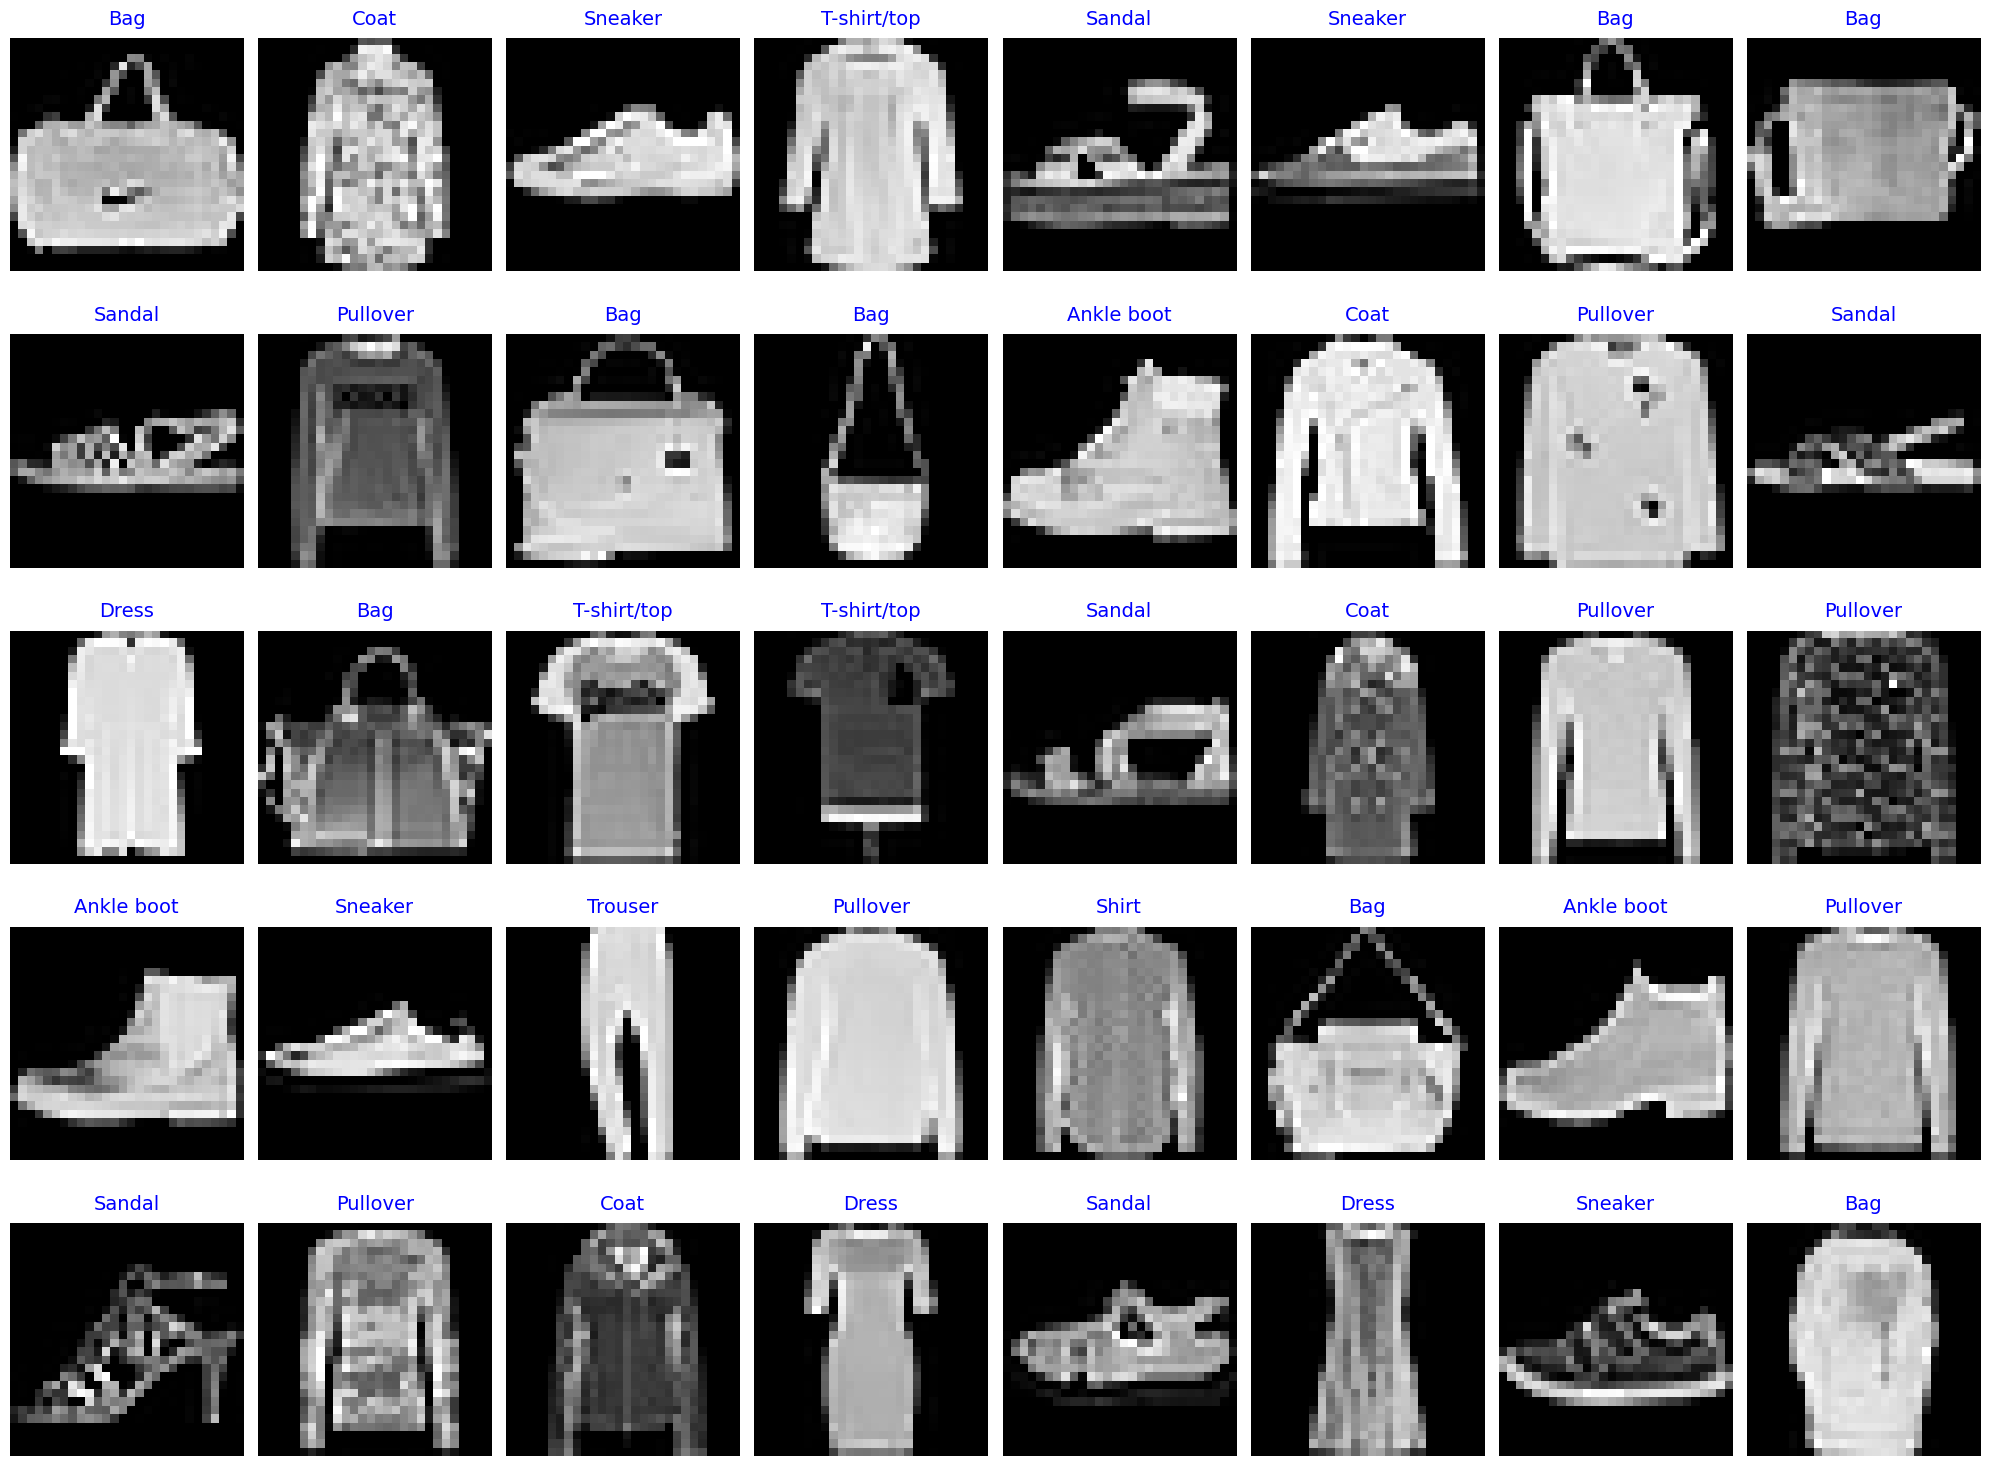

In [12]:
figure_dims = (8,5)  # 8 rows, 5 columns
show_in_plot(figure_dims, current_train_loader, None)

# Training and evaluation loops, as seen in class

In [13]:
def train_model(num_epochs, model, train_loader, loss_fn, optimizer, device):
  # Train the model
  for epoch in range(num_epochs):
      total_loss = 0
      model.train()
      for images, labels in train_loader:
          # The iterator returns a pair  (images,labels):
          # Images size will be:  (28,28,64) and labels : (1,64)

          # Using images.to(device)
          #  This loads the data into device memory (e.g. GPU)
          images, labels = images.to(device), labels.to(device)

          # Forward pass
          outputs = model(images)
          loss = loss_fn(outputs, labels)

          # Backward pass (backpropagation)
          optimizer.zero_grad()
          loss.backward()
          # Update the weights according to the derivatives
          optimizer.step()

          total_loss += loss.item()
          # print(f"    Epoch {epoch+1}, Temporary Loss: {loss.item():.4f}")

      print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

def eval_model(model, test_loader, device):
  # Evaluate on test set
  correct = 0
  total = 0
  model.eval()
  with torch.no_grad():
      for images, labels in test_loader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)

          # Translate the probabilities to choose one output
          _, predicted = torch.max(outputs, 1)

          # The size of labels is (64,1)
          total += labels.size(0)  # Only the "64"

          correct += (predicted == labels).sum().item()
  return correct, total


# Calculate and display predictions - extended version of what was shown in class

In [14]:
def calculate_predictions(model, data_loader, device, just_one_batch=False):
    all_labels = []
    all_preds = []
    all_images = []

    model.eval()
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_labels.append(labels)
            all_preds.append(preds)
            all_images.append(images.cpu())  # Detach and move to CPU

            if just_one_batch:
                break

    all_labels = torch.cat(all_labels)
    all_preds = torch.cat(all_preds)
    all_images = torch.cat(all_images)

    return all_images, all_labels, all_preds


def show_predictions(images, labels, preds, classes):
    assert len(labels) == len(preds) == len(images)

    labels_and_preds_strings = [
        f"Label: {classes[label]}\nPred: {classes[pred]} {arrow}"
        for label, pred in zip(labels, preds, strict=True)
    ]
    title_colors = [
        "red" if label != pred else "blue" for label, pred in zip(labels, preds, strict=True)
    ]

    # Use the image tensors directly, not the loader
    # Wrap into (img, label) tuples for the plotting function
    samples = list(zip(images, labels, strict=True))
    show_in_plot((6, 6), samples, labels_and_preds_strings, title_colors)

In [15]:
## Define MLP model
##   Old model:
# class MLP(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.model = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(28*28, 256),
#             nn.ReLU(),
#             nn.Linear(256, 128),
#             nn.ReLU(),
#             nn.Linear(128, 10)
#         )

#     def forward(self, x):
#         return self.model(x)


# New model (Simpler)
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 10)
        )

    def forward(self, x):
        return self.model(x)

In [16]:
# Define the model and hyper-parameters
model = MLP().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
# Train the model
num_epochs = 3
train_model(num_epochs,model,current_train_loader,loss_fn,optimizer,device)

Epoch 1, Loss: 1042.0442
Epoch 2, Loss: 611.9149
Epoch 3, Loss: 553.7712


In [18]:
# Calculate accuracy on test set
correct, total = eval_model(model, current_test_loader, device)
print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 79.12%


# Display some predictions on the test set, based on one batch

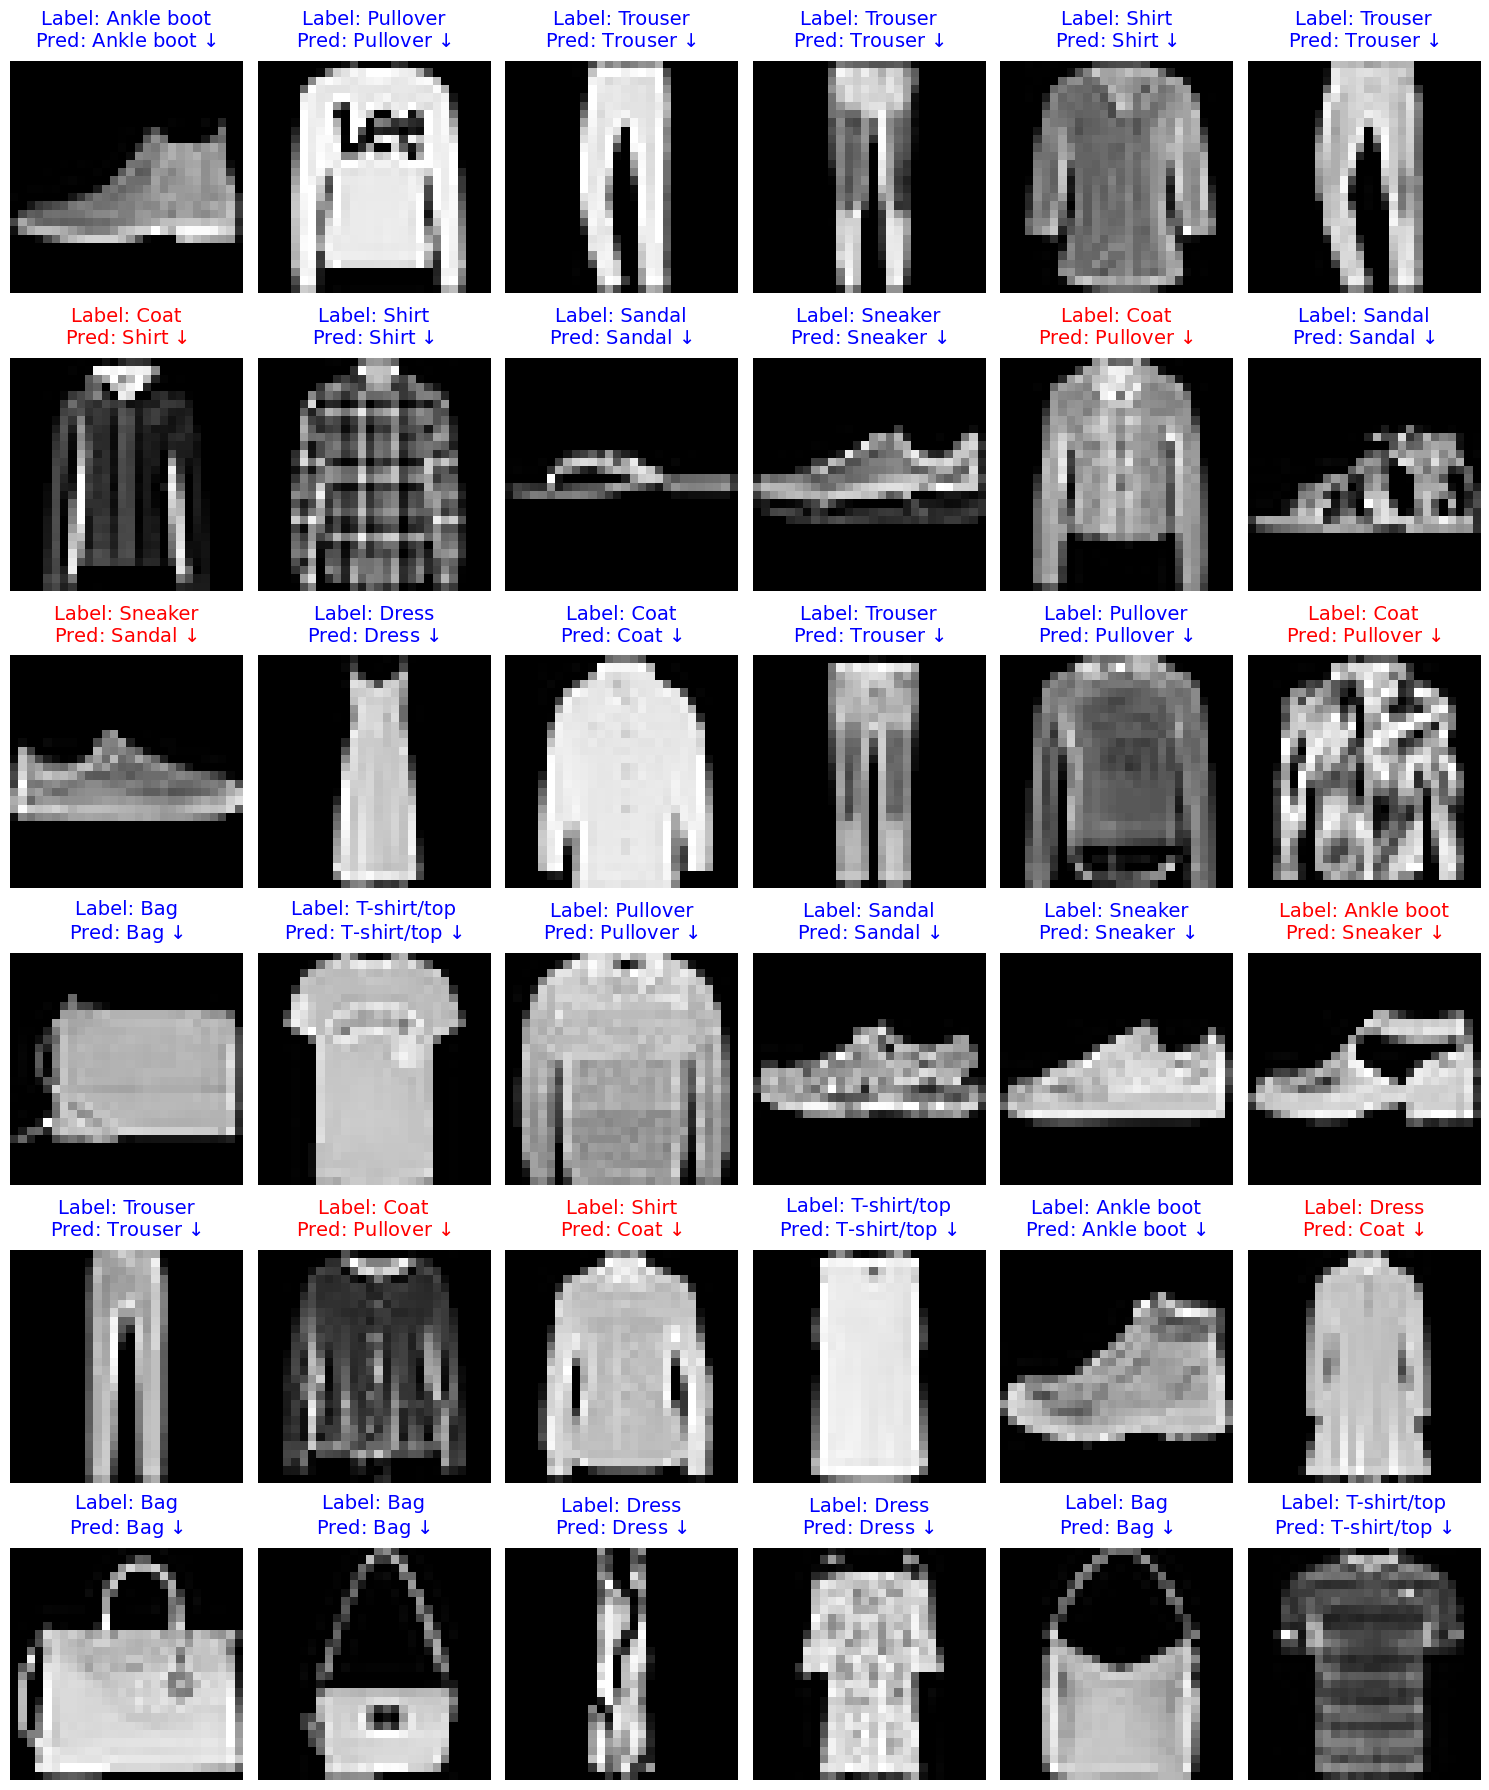

In [19]:
images, labels, preds = calculate_predictions(model, current_test_loader, device, just_one_batch=True)
show_predictions(images, labels, preds, train_data.classes)